데이터 셋 K-Fold 분할 구현

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from pathlib import Path
import os

# CSV 파일 로드 (한글 경로/인코딩 문제 대응)
csv_path = 'C:/Users/AI-LHJ/Desktop/Task/labels.csv'
try:
    df = pd.read_csv(csv_path, encoding='cp949')
    print("CSV 파일을 cp949 인코딩으로 로드했습니다.")
except Exception:
    df = pd.read_csv(csv_path, encoding='utf-8-sig')
    print("CSV 파일을 utf-8-sig 인코딩으로 로드했습니다.")

# 레이블 인코딩
le = LabelEncoder()
df['style'] = le.fit_transform(df['style'])
class_names = le.classes_.tolist()
print(f"스타일 클래스: {class_names}")

# 이미지 절대경로 생성
root_img_dir = 'C:/Users/AI-LHJ/Desktop/Task/images'
def abs_path(rel_path):
    return str((Path(root_img_dir) / rel_path).resolve())
df['abs_path'] = df['image_path'].apply(abs_path)

# K-폴드 교차 검증 설정
n_splits = 5  # 5-폴드 교차 검증
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

CSV 파일을 cp949 인코딩으로 로드했습니다.
스타일 클래스: ['걸리시', '고프코어', '레트로', '로맨틱', '리조트', '미니멀', '스트릿', '스포티', '시크', '시티보이', '에스닉', '워크웨어', '캐주얼', '클래식', '프레피']


한글 폰트 설정

윈도우 기본 한글 폰트(맑은 고딕) 설정 완료


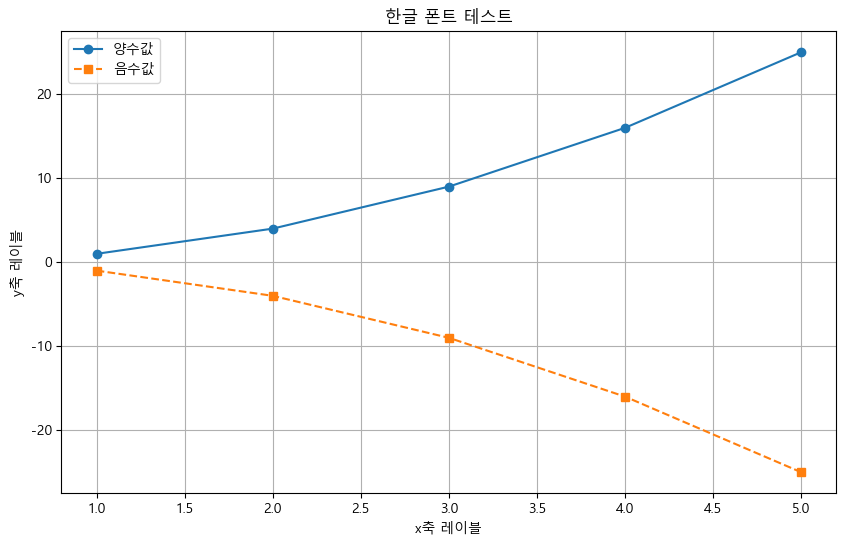

In [2]:
# 문제 2: Matplotlib에서 한글 표시 설정

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 방법 1: 윈도우 기본 한글 폰트 사용
def set_korean_font_windows():
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
    plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지
    print("윈도우 기본 한글 폰트(맑은 고딕) 설정 완료")

# 방법 2: 나눔 폰트 사용
def set_korean_font_nanum():
    # 나눔 폰트 경로 설정 (윈도우 기준)
    font_path = 'C:/Windows/Fonts/NanumGothic.ttf'  # 나눔고딕 폰트 경로
    
    try:
        # 폰트 속성 가져오기
        font_prop = fm.FontProperties(fname=font_path)
        font_name = font_prop.get_name()
        
        # 폰트 설정
        plt.rc('font', family=font_name)
        plt.rc('axes', unicode_minus=False)
        print("나눔고딕 폰트 설정 완료")
    except:
        print("나눔고딕 폰트 설정 실패. 다른 방법 시도")
        try_other_korean_fonts()

# 방법 3: 시스템에서 사용 가능한 한글 폰트 찾기
def try_other_korean_fonts():
    # 시스템에 설치된 폰트 목록 가져오기
    font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    
    # 한글 폰트 후보들
    korean_fonts = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 
                   'NanumSquare', 'Gulim', 'Batang', 'Dotum']
    
    found = False
    for font in korean_fonts:
        try:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            print(f"'{font}' 폰트 설정 완료")
            found = True
            break
        except:
            continue
    
    if not found:
        print("한글 폰트를 찾을 수 없습니다. 폰트 설치가 필요합니다.")
        print("나눔 폰트 설치 방법:")
        print("1. pip install matplotlib-korean-font")
        print("또는")
        print("2. 윈도우: 나눔 폰트 다운로드 후 C:/Windows/Fonts에 설치")
        print("3. 리눅스: sudo apt-get install fonts-nanum")

# 테스트 그래프 그리기
def test_korean_font():
    plt.figure(figsize=(10, 6))
    
    x = [1, 2, 3, 4, 5]
    y1 = [1, 4, 9, 16, 25]
    y2 = [-1, -4, -9, -16, -25]
    
    plt.plot(x, y1, 'o-', label='양수값')
    plt.plot(x, y2, 's--', label='음수값')
    
    plt.title('한글 폰트 테스트')
    plt.xlabel('x축 레이블')
    plt.ylabel('y축 레이블')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# 실행: 윈도우 환경에서는 보통 이 방법이 가장 잘 작동합니다
set_korean_font_windows()
# 만약 위 방법이 작동하지 않으면 아래 방법들을 순서대로 시도해보세요
# set_korean_font_nanum()
# try_other_korean_fonts()

# 테스트 그래프 그리기
test_korean_font()


이미지 전처리 및 데이터셋 생성 함수

In [3]:
# 이미지 크기 설정 (모델별로 다른 값 사용 가능)
IMG_SIZE = 224

# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

# 이미지 전처리 함수
def preprocess_for_model(model_name, img):
    """모델별 전처리 함수"""
    if model_name == 'mobilenetv2':
        return tf.keras.applications.mobilenet_v2.preprocess_input(img)
    elif model_name == 'efficientnetv2':
        return tf.keras.applications.efficientnet_v2.preprocess_input(img)
    elif model_name == 'resnet50':
        return tf.keras.applications.resnet50.preprocess_input(img)
    else:
        # 기본 정규화
        return img / 255.0

def load_and_preprocess_image(path, model_name='mobilenetv2'):
    """이미지 로드 및 전처리"""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_for_model(model_name, img)
    return img

# 데이터셋 생성 함수
def create_dataset(df, model_name='mobilenetv2', batch_size=32, augment=False):
    """데이터셋 생성 함수"""
    paths = df['abs_path'].astype(str).values
    labels = df['style'].values.astype('int32')
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    # 이미지 로드 및 전처리
    dataset = dataset.map(
        lambda x, y: (load_and_preprocess_image(x, model_name), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # 증강 적용 (학습 데이터셋에만)
    if augment:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


다양한 모델 아키텍처 정의 함수

In [10]:
def create_model(model_name, num_classes):
    """다양한 사전훈련된 모델 생성 함수"""
    
    # 기본 모델 초기화
    base_model = None
    
    if model_name == 'mobilenetv2':
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=(IMG_SIZE, IMG_SIZE, 3), 
            include_top=False, 
            weights='imagenet'
        )
    elif model_name == 'efficientnetv2s':
        base_model = tf.keras.applications.EfficientNetV2S(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
    elif model_name == 'resnet50':
        base_model = tf.keras.applications.ResNet50(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
    elif model_name == 'vgg16':
        base_model = tf.keras.applications.VGG16(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
    
    if base_model is None:
        raise ValueError(f"Unsupported model name: {model_name}")
        
    base_model.trainable = False
    
    # 모델 구성
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


K-폴드 교차 검증을 통한 모델 학습 및 평가

In [5]:
def train_kfold_model(df, model_name, epochs=10):
    """K-폴드 교차 검증으로 모델 학습 및 평가"""
    
    num_classes = len(np.unique(df['style']))
    fold_accuracies = []
    fold_models = []
    
    # K-fold 분할 수행
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df)):
        print(f"===== 폴드 {fold+1}/{n_splits} 학습 =====")
        
        # 훈련/검증 데이터 분리
        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df = df.iloc[val_idx].reset_index(drop=True)
        
        # 데이터셋 생성
        train_dataset = create_dataset(train_df, model_name=model_name, augment=True)
        val_dataset = create_dataset(val_df, model_name=model_name, augment=False)
        
        # 폴드별 모델 생성
        model = create_model(model_name, num_classes)
        
        # 폴드별 체크포인트 설정
        checkpoint_path = f'best_model_{model_name}_fold_{fold+1}.h5'
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path, 
            save_best_only=True, 
            monitor='val_accuracy'
        )
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )
        
        # 학습률 스케줄러 추가
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5,
            patience=1,
            min_lr=0.00001
        )        
        # 모델 학습
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=[checkpoint, early_stopping, reduce_lr]
        )


        # 검증 세트에 대한 성능 평가
        val_loss, val_acc = model.evaluate(val_dataset)
        print(f"폴드 {fold+1} 검증 정확도: {val_acc:.4f}")
        
        fold_accuracies.append(val_acc)
        fold_models.append(model)
        
        # 폴드별 학습 곡선 시각화
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='훈련 정확도')
        plt.plot(history.history['val_accuracy'], label='검증 정확도')
        plt.title(f'폴드 {fold+1} 정확도')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='훈련 손실')
        plt.plot(history.history['val_loss'], label='검증 손실')
        plt.title(f'폴드 {fold+1} 손실')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # K-폴드 평균 성능
    avg_acc = np.mean(fold_accuracies)
    print(f"\n{n_splits}-폴드 평균 검증 정확도: {avg_acc:.4f}")
    print(f"각 폴드 검증 정확도: {fold_accuracies}")
    
    return fold_models, fold_accuracies


모델 비교 및 선택

In [6]:
def compare_models(df, model_names, epochs=10):
    """여러 모델 아키텍처 비교"""
    
    results = {}
    
    for model_name in model_names:
        print(f"\n======= {model_name} 모델 학습 =======")
        fold_models, fold_accuracies = train_kfold_model(df, model_name, epochs)
        results[model_name] = {
            'models': fold_models,
            'accuracies': fold_accuracies,
            'avg_accuracy': np.mean(fold_accuracies)
        }
    
    # 모델 비교 시각화
    model_names_list = list(results.keys())
    avg_accs = [results[name]['avg_accuracy'] for name in model_names_list]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names_list, avg_accs)
    plt.title('모델별 평균 정확도 비교')
    plt.ylabel('평균 정확도')
    plt.ylim(0, 1.0)
    
    # 막대 위에 정확도 값 표시
    for bar, acc in zip(bars, avg_accs):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.01,
            f'{acc:.4f}',
            ha='center'
        )
    
    plt.show()
    
    # 가장 좋은 모델 선택
    best_model_name = max(results, key=lambda x: results[x]['avg_accuracy'])
    print(f"\n최고 성능 모델: {best_model_name}, 평균 정확도: {results[best_model_name]['avg_accuracy']:.4f}")
    
    return results, best_model_name


최종 모델 학습 및 저장

In [7]:
def train_final_model(df, best_model_name, epochs=15):
    """전체 데이터로 최종 모델 학습"""
    
    num_classes = len(np.unique(df['style']))
    
    # 훈련/테스트 데이터 분리 (최종 평가용)
    from sklearn.model_selection import train_test_split
    train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['style'], random_state=42)
    
    # 데이터셋 생성
    train_dataset = create_dataset(train_df, model_name=best_model_name, augment=True)
    test_dataset = create_dataset(test_df, model_name=best_model_name, augment=False)
    
    # 최종 모델 생성
    final_model = create_model(best_model_name, num_classes)
    
    # 점진적 미세조정 적용
    if best_model_name != 'mobilenetv2':  # 더 깊은 모델에 대해 미세조정 적용
        print("점진적 미세조정 적용...")
        
        # 1단계: 특징 추출 (기본 모델 동결)
        final_model.fit(
            train_dataset,
            epochs=5,
            validation_data=test_dataset
        )
        
        # 2단계: 상위 레이어 미세조정
        for layer in final_model.layers[0].layers[-20:]:
            layer.trainable = True
            
        # 더 낮은 학습률로 컴파일
        final_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    
    # 최종 학습
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_final_model.h5',
        save_best_only=True,
        monitor='val_accuracy'
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
    
    history = final_model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset,
        callbacks=[checkpoint, early_stopping]
    )
    
    # 최종 테스트 평가
    test_loss, test_acc = final_model.evaluate(test_dataset)
    print(f"\n최종 테스트 정확도: {test_acc:.4f}")
    
    # 학습 곡선 시각화
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='훈련 정확도')
    plt.plot(history.history['val_accuracy'], label='검증 정확도')
    plt.title('정확도')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='훈련 손실')
    plt.plot(history.history['val_loss'], label='검증 손실')
    plt.title('손실')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 모델 저장
    final_model.save(f'final_{best_model_name}_model.h5')
    
    return final_model, history


추론 및 사용 예시

In [8]:
class StyleClassifier:
    """스타일 분류기 클래스"""
    
    def __init__(self, model_path, class_names, model_name='mobilenetv2'):
        self.model = tf.keras.models.load_model(model_path)
        self.class_names = class_names
        self.model_name = model_name
        
    def predict_style(self, image_path):
        """이미지 스타일 예측"""
        # 입력 경로를 절대경로로 변환
        abs_path = str(Path(image_path).resolve())
        img = load_and_preprocess_image(abs_path, self.model_name)
        img = tf.expand_dims(img, axis=0)
        pred = self.model.predict(img)
        
        # 확률 상위 3개 예측 결과 반환
        top_indices = tf.argsort(pred[0], direction='DESCENDING')[:3].numpy()
        top_probs = tf.sort(pred[0], direction='DESCENDING')[:3].numpy()
        
        results = []
        for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
            results.append({
                'rank': i+1,
                'style': self.class_names[idx],
                'probability': float(prob)
            })
        
        return results


모델 비교 및 최종 실행


======= mobilenetv2 모델 학습 =======
===== 폴드 1/5 학습 =====
Epoch 1/5
8048/8048 [==============================] - 312s 39ms/step - loss: 0.3524 - accuracy: 0.9757 - val_loss: 37.9609 - val_accuracy: 0.0132 - lr: 0.0010
Epoch 2/5
8048/8048 [==============================] - 297s 37ms/step - loss: 0.2853 - accuracy: 0.9628 - val_loss: 40.2950 - val_accuracy: 0.0132 - lr: 0.0010
Epoch 3/5
8048/8048 [==============================] - 300s 37ms/step - loss: 0.2632 - accuracy: 0.9524 - val_loss: 17.8126 - val_accuracy: 0.0132 - lr: 5.0000e-04
Epoch 4/5
2012/2012 [==============================] - 49s 24ms/step - loss: 37.9609 - accuracy: 0.0132
폴드 1 검증 정확도: 0.0132


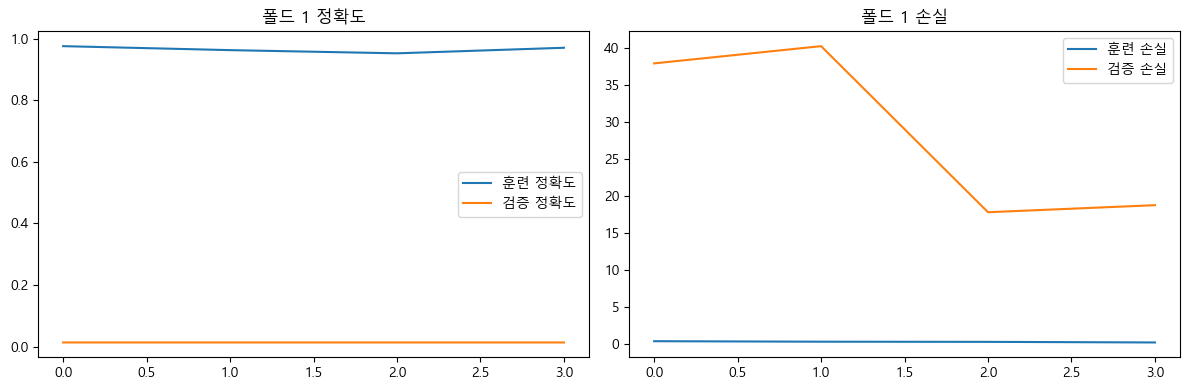

===== 폴드 2/5 학습 =====
Epoch 1/5
6458/8048 [=======================>......] - ETA: 50s - loss: 0.3672 - accuracy: 0.9727

KeyboardInterrupt: 

In [12]:
# 실행 예시
if __name__ == "__main__":
    # 1. 다양한 모델 비교
    model_names = ['mobilenetv2', 'efficientnetv2s', 'resnet50', 'vgg16']
    results, best_model_name = compare_models(df, model_names, epochs=5)
    
    # 2. 최고 성능 모델로 최종 모델 학습
    final_model, history = train_final_model(df, best_model_name, epochs=15)
    
    # 3. 모델 사용 예시
    classifier = StyleClassifier(
        f'final_{best_model_name}_model.h5',
        class_names,
        model_name=best_model_name
    )
    
    # 테스트 이미지에 대한 예측
    test_img_path = 'C:/Users/AI-LHJ/Desktop/Task/images/캐주얼/001_reg/캐주얼_407345.jpg'
    results = classifier.predict_style(test_img_path)
    
    for result in results:
        print(f"순위 {result['rank']}: {result['style']} (확률: {result['probability']:.4f})")
